In [72]:
import os 
import datetime 
import importlib 
import torchkeras 
#打印时间 
def printbar():    
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')    
    print("\n"+"=========="*8 + "%s"%nowtime) 
#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

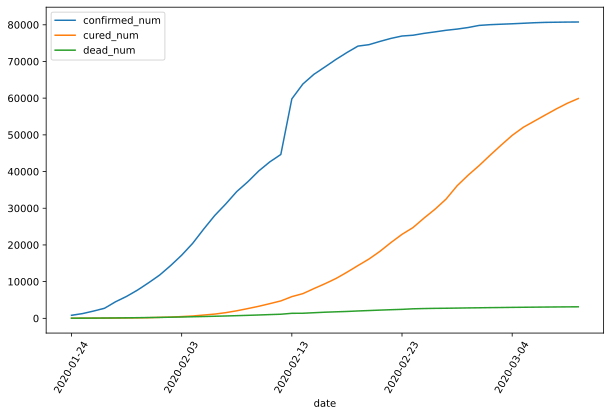

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("../data/covid-19/covid-19.csv",sep="\t")
df.plot(x="date",y=["confirmed_num","cured_num","dead_num"],figsize = (10,6))
plt.xticks(rotation = 60);

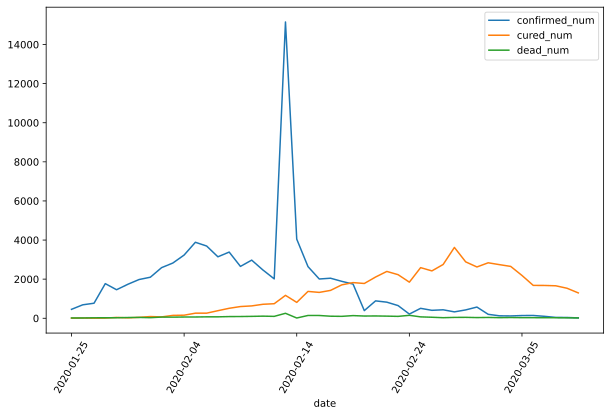

In [74]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods = 1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x="date", y = ["confirmed_num", "cured_num", "dead_num"],figsize=(10,6))
plt.xticks(rotation = 60)
dfdiff = dfdiff.drop("date", axis = 1).astype("float32")

In [75]:
dfdiff.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


In [93]:
# 下面通过继承torch.utils.data.Dataset实现自定义时间序列数据集。 
# torch.utils.data.Dataset是一个抽象类，
# 用户想要加载自定义的数据只需要继承这个类，
# 并且覆 写其中的两个方法即可： 
# __len__ :实现len(dataset)返回整个数据集的大小。
# __getitem__ :用来获取一些索引的数据，使dataset[i]返回数据集中第i个样本。 
# 不覆写这两个方法会直接返回错误。

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader,TensorDataset

WINDOW_SIZE = 8
class Covid19Dataset(Dataset):
    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE
    
    def __getitem__(self,i):
        x = dfdiff.loc[i:i+WINDOW_SIZE-1,:]
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i+WINDOW_SIZE,:]
        label = torch.tensor(y.values)
        return (feature, label)
    
ds_train = Covid19Dataset()

# 由于数据较小，将所有数据放入一个batch，提升性能
dl_train = DataLoader(ds_train, batch_size = 38)

In [94]:
# 二，定义模型 
# 使用Pytorch通常有三种方式构建模型：
# 使用nn.Sequential按层顺序构建模型，
# 继承nn.Module 基类构建自定义模型，
# 继承nn.Module基类构建模型并辅助应用模型容器进行封装。 

# 此处选择第二种方式构建模型。 

# 由于接下来使用类形式的训练循环，
# 我们进一步将模型封装成torchkeras中的Model类
# 来获得类似Keras中高阶模型接口的功能。 

# Model类实际上继承自nn.Module类

import torch
from torch import nn
import importlib
import torchkeras

torch.random.seed()

class Block(nn.Module):
    def __init__(self):
        super(Block,self).__init__()
    def forward(self, x, x_input):
        x_out = torch.max((1+x)*x_input[:,-1,:],torch.tensor(0.0))
        return x_out

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
#         开始创建三层LSTM
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=5, batch_first=True)
        self.linear = nn.Linear(3,3)
        self.block = Block()
        
    def forward(self,x_input):
        x = self.lstm(x_input)[0][:,-1,:]
        x = self.linear(x)
        y = self.block(x,x_input)
        return y

net = Net()
model = torchkeras.Model(net)
print(model)

model.summary(input_shape=(8,3),input_dtype = torch.FloatTensor)

Model(
  (net): Net(
    (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (block): Block()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                    [-1, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002197
----------------------------------------------------------------


In [95]:
# 三，训练模型 
# 训练Pytorch通常需要用户编写自定义训练循环，
# 训练循环的代码风格因人而异。

# 有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。 

# 此处 仿照Keras定义了一个高阶的模型接口Model,
# 实现 fit, validate，predict, summary 方法，相当于用户自定义高阶API。 

# 注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果

# def mspe(y_pred,y_true):
#     err_percent = (y_true - ty_pred)**2 / (torch.max(y_true**2,torch.tensor(1e-7)))
#     return torch.mean(err_percent)
# model.compile(loss_func=mspe, optimizer=torch.optim.Adagrad(model.parameters(), lr = 0.1))


def mspe(y_pred,y_true):    
    err_percent = (y_true - y_pred)**2/(torch.max(y_true**2,torch.tensor(1e-7)))    
    return torch.mean(err_percent)
model.compile(loss_func = mspe,optimizer = torch.optim.Adagrad(model.parameters(),lr = 0.1))

In [96]:
dfhistory = model.fit(100,dl_train,log_step_freq=10)

Start Training ...

================================================================================2021-09-25 16:01:05

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 4.439 |
+-------+-------+

================================================================================2021-09-25 16:01:05

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 2.778 |
+-------+-------+

================================================================================2021-09-25 16:01:05

 +-------+------+
| epoch | loss |
+-------+------+
|   3   | 1.88 |
+-------+------+

================================================================================2021-09-25 16:01:05

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   4   | 1.116 |
+-------+-------+

================================================================================2021-09-25 16:01:05

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   5   | 0.544 |
+-------+-------+

====================


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   44  | 0.276 |
+-------+-------+

================================================================================2021-09-25 16:01:06

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   45  | 0.276 |
+-------+-------+

================================================================================2021-09-25 16:01:06

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   46  | 0.275 |
+-------+-------+

================================================================================2021-09-25 16:01:06

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   47  | 0.275 |
+-------+-------+

================================================================================2021-09-25 16:01:06

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   48  | 0.275 |
+-------+-------+

================================================================================2021-09-25 16:01:06

 +-------+-------+
| epoch |  loss


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   88  | 0.274 |
+-------+-------+

================================================================================2021-09-25 16:01:07

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   89  | 0.271 |
+-------+-------+

================================================================================2021-09-25 16:01:07

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   90  | 0.271 |
+-------+-------+

================================================================================2021-09-25 16:01:07

 +-------+------+
| epoch | loss |
+-------+------+
|   91  | 0.27 |
+-------+------+

================================================================================2021-09-25 16:01:07

 +-------+------+
| epoch | loss |
+-------+------+
|   92  | 0.27 |
+-------+------+

================================================================================2021-09-25 16:01:07

 +-------+-------+
| epoch |  loss |
+------

In [104]:
# 四、评估模型

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1,len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training_' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric])
    plt.show()

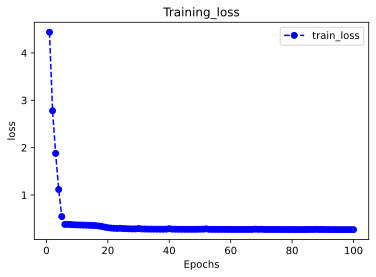

In [105]:
plot_metric(dfhistory,"loss")

In [106]:
# 五、使用模型
# 这里我们使用模型预测疫情结束的时间。
# 即新增确诊病例为0的时间。

dfresult = dfdiff[["confirmed_num", "cured_num", "dead_num"]].copy()

dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [114]:
# 预测此后200天的新增走势，将结果添加到dfresult中
for i in range(200):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]),axis = 0)
    arr_predict = model.forward(arr_input)
    
    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(), columns= dfresult.columns)
    dfresult = dfresult.append(dfpredict, ignore_index=True)

In [110]:
dfresult.query("confirmed_num == 0").head()

,confirmed_num,cured_num,dead_num
50,0.0,948.0,3.0
51,0.0,890.0,2.0
52,0.0,835.0,1.0
53,0.0,783.0,0.0
54,0.0,734.0,0.0


In [111]:
# 第50天新增确诊降为0。
# 该预测偏向乐观

In [112]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num
123,0.0,0.0,0.0
124,0.0,0.0,0.0
125,0.0,0.0,0.0
126,0.0,0.0,0.0
127,0.0,0.0,0.0


In [113]:
# 第123天开始新增治愈降为0，第45天对应3月10日，也就是大概3个月后，即6月10日左右全部治愈
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数

In [115]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
53,0.0,783.0,0.0
54,0.0,734.0,0.0
55,0.0,688.0,0.0
56,0.0,645.0,0.0
57,0.0,605.0,0.0


In [ ]:
# 第53天开始死亡病例降为0，
# 第45天对应3月10日，也就是5天后，即预计3月15日新增确诊降为0 
# 注：该预测偏乐观
